# Rianna's ML models

In [1]:
# import data
import pickle
with open("data_splits.pkl", "rb") as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

## ML Models

### Method: XGBoost

In [2]:
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

#### Plotting function

In [9]:
# helper function
import matplotlib.pyplot as plt

def plot_train_val_losses(eval_scores):
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    for fold in range(5):
        fold_scores = eval_scores[fold]
        axes[fold].plot(fold_scores['validation_0']['rmse'], label="Train Loss")
        axes[fold].plot(fold_scores['validation_1']['rmse'], label="Validation Loss")
        axes[fold].set_title(f"Fold {fold+1}")
        axes[fold].set_xlabel("Boosting Rounds")
        axes[fold].set_ylabel("RMSE Loss")
        axes[fold].legend()
    
    plt.tight_layout()
    plt.show()

In [4]:
def plot_actual_vs_predicted(y_test, y_pred):
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs Predicted")
    plt.show()

#### Hyperparameter tuning  and regularization with RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist = {
    'learning_rate': uniform(0.001, 0.2),
    'max_depth': randint(3, 10),
    'n_estimators': randint(50, 400),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1), # L1 regularization
    'reg_lambda': uniform(0, 10) # L2 regularization
}

xgb = XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best hyperparameters found:", best_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters found: {'colsample_bytree': np.float64(0.9895022075365837), 'learning_rate': np.float64(0.04755426808606085), 'max_depth': 8, 'n_estimators': 224, 'reg_alpha': 0.1, 'reg_lambda': 10, 'subsample': np.float64(0.7529847965068651)}


#### K-Fold Cross-Validation

Fold 1 — Train MSE: 0.3910
Fold 2 — Train MSE: 0.4549
Fold 3 — Train MSE: 0.3812
Fold 4 — Train MSE: 0.3976
Fold 5 — Train MSE: 0.4372


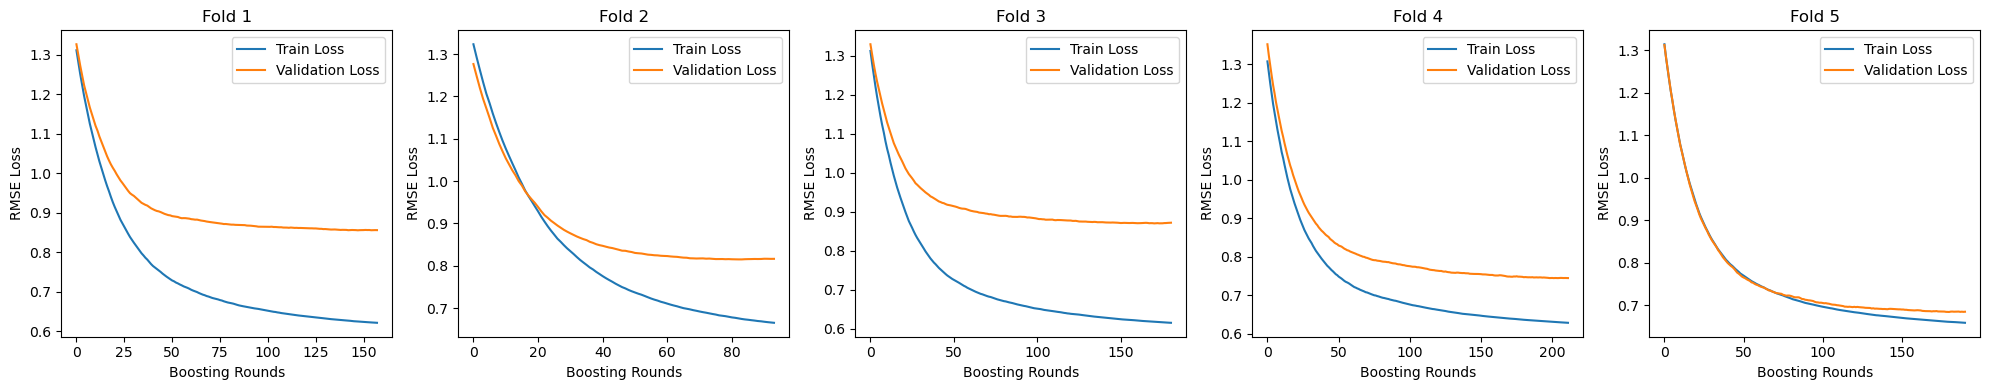

Average Train MSE: 0.4124 ± 0.0285


In [10]:
# 5 fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

train_mse_scores = []
eval_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    # X_train_in, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    # y_train_in, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    X_train_in, X_val = X_train[train_idx], X_train[val_idx] 
    y_train_in, y_val = y_train[train_idx], y_train[val_idx]

    xgb_model = XGBRegressor(
        **best_params,
        random_state=42,
        eval_metric="rmse",
        early_stopping_rounds=10,
        n_jobs=-1
    )

    xgb_model.fit(
        X_train_in,
        y_train_in,
        eval_set= [(X_train_in, y_train_in), (X_val, y_val)], #[(X_val, y_val)],
        verbose=False,
    )

    evals_result = xgb_model.evals_result()
    eval_scores.append(evals_result)

    y_train_pred = xgb_model.predict(X_train_in)
    train_mse = mean_squared_error(y_train_in, y_train_pred)
    train_mse_scores.append(train_mse)

    print(f"Fold {fold + 1} — Train MSE: {train_mse:.4f}")
    
plot_train_val_losses(eval_scores)

print(f"Average Train MSE: {np.mean(train_mse_scores):.4f} ± {np.std(train_mse_scores):.4f}")

#### Test Results

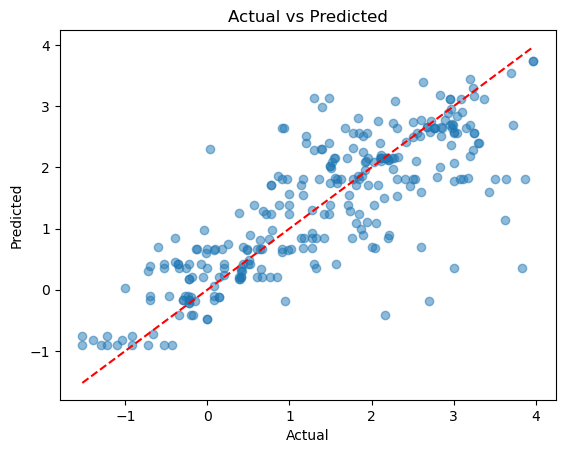

1.6623690797491995
Final Test MSE: 0.5728
Final Test R²: 0.6554


In [11]:
# remake new model on best params
xgb_model = XGBRegressor(
    **best_params,
    random_state=42,
    eval_metric="rmse",
    n_jobs=-1
)
# xgb_model.early_stopping_rounds = None
xgb_model.fit(X_train, y_train) # Re-fit on all training data
y_test_pred = xgb_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

plot_actual_vs_predicted(y_test, y_test_pred)
print(np.var(y_test))

print(f"Final Test MSE: {test_mse:.4f}")
print(f"Final Test R²: {test_r2:.4f}")

[0.2071701  0.13745478 0.13253303 0.21503143 0.16675591 0.14105476]


<Figure size 800x1200 with 0 Axes>

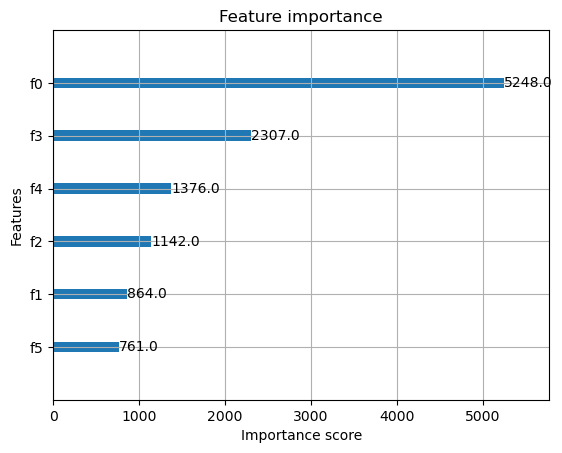

In [12]:
feat_imps = xgb_model.feature_importances_
print(feat_imps)
plt.figure(figsize=(8, 12))
xgboost.plot_importance(xgb_model)
plt.show()